# Avoiding catastrophic interference with dreams (activation maximization)

The test is performed on MNIST data.

In "plain" version, all auxiliary cod is removed

**Warning**: dreams generation is extremely slow

In [1]:
import os
# Disable GPU in a case of kernel freezing
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras import utils
from keras import regularizers
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import toimage
%matplotlib inline 
import PIL.Image as pil
from progressbar import ProgressBar  # pip install progressbar33
from keras import optimizers
from keras.callbacks import EarlyStopping
from scipy.special import expit
import pickle

Using TensorFlow backend.


In [3]:
# hyperparameters for the main neural network
num_epoch = 20
num_neur = 400 # number of neurons in hidden layers
num_class = 10
img_line = 784
#vspl = 0.2
bsize = 32
l2 = 1e-4 # L2 regularization

# hyperparamerets for dreams generation
nb_dreams = 2000 # number of dreams generated per class
# WARNING! Too big llr may result in solver converging to the same local minimum
llr = 0.01 # learning rate for dream-generating network
ll2 = 0.01 # prior weights distribution
min_delta=0.0003 # stop criterion for gradient descend
dream_epochs = 8000

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
X_train = X_train.reshape(60000, img_line)
X_train = X_train.astype('float32')
X_train /= 255
X_test = X_test.reshape(10000, img_line)
X_test = X_test.astype('float32')
X_test /= 255

Y_train = utils.to_categorical(y_train, 10)
Y_test = utils.to_categorical(y_test, 10)

model = Sequential()
model.add(Dense(num_neur, input_dim=img_line, activation="relu",kernel_regularizer=regularizers.l2(l2)))
model.add(Dense(num_neur, activation="relu",kernel_regularizer=regularizers.l2(l2)))
model.add(Dense(num_class, activation="softmax",kernel_regularizer=regularizers.l2(l2)))

model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.001), metrics=["accuracy"])

## Training network  on data A

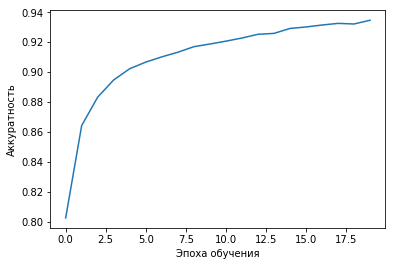

In [6]:
if os.path.isfile('weights_a.h5'): # if network was trained before
    model.load_weights("weights_a.h5") # load weights
    score_a = np.load('score_a.npy') # load training history for data A
    order_a = np.loadtxt('order_a.txt', dtype=int) # load permutation order of data A
    # Restore permitted data A
    tr_a = X_train[:,order_a]
    ts_a = X_test[:,order_a]
else: # train network from begining if not trained before
    order_a = np.random.permutation(img_line)
    np.savetxt('order_a.txt', order_a, fmt='%d') # save permutation order
    tr_a = X_train[:,order_a]
    ts_a = X_test[:,order_a]

    score_a = np.zeros((num_epoch,2))
    history = model.fit(tr_a, Y_train, batch_size=bsize, epochs=num_epoch, validation_data=(ts_a,Y_test), verbose=0)
    model.save_weights('weights_a.h5') # save weights for further use
    score_a[:,0] = range(num_epoch)
    score_a[:,1] = history.history['val_acc']
    np.save('score_a', score_a)

    plt.plot(score_a[:,0],score_a[:,1])
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Аккуратность')
    plt.show()

## Generate dreams about data A

In [7]:
# Freeze all the layers in the trained network
for layer in model.layers:
    layer.trainable = False

# Create network for dreams production
model_dream = Sequential()
model_dream.add(Dense(img_line,input_dim=1,kernel_initializer="uniform",
                      kernel_regularizer=regularizers.l2(ll2),activation='sigmoid',use_bias=False))
model_dream.add(model)
sgd = optimizers.SGD(lr=llr)
model_dream.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=["accuracy"])

Generate dream for a one class

In [8]:
# early_stopping = EarlyStopping(monitor='loss', min_delta=min_delta)
# neuron = 9 # output neuron for activation maximization
# x_in = np.array([[1]])
# y_out = np.zeros((1,num_class))
# y_out[0][neuron] = 1
# nb_dreams = X_train.shape[0]//num_class # number of dreams per node
# weights = np.array([[2*np.random.randn(img_line)]])
# model_dream.layers[0].set_weights(weights) # initialize dream with random distribution 
# history = model_dream.fit(x_in,y_out,batch_size=1,epochs=dream_epochs,verbose=0,shuffle=False,callbacks=[early_stopping])
# plt.plot(history.history['loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.show()

Create array of dreams starting from random noise

In [9]:
early_stopping = EarlyStopping(monitor='loss', min_delta=min_delta)

x_in = np.array([[1]])
for node in range(num_class): # generate dreams for every output node
    y_out = np.zeros((1,num_class))
    y_out[0][node] = 1 # create output target
    print('Creating dreams for node #%d' % (node))
    pbar = ProgressBar(maxval=nb_dreams).start()
    dreams = np.zeros((nb_dreams,img_line))
    for ind in range(nb_dreams):
        weights = np.array([[2*np.random.randn(img_line)]])
        model_dream.layers[0].set_weights(weights) # initialize dream with random distribution 
        model_dream.fit(x_in,y_out,batch_size=1,epochs=dream_epochs,verbose=0,shuffle=False,callbacks=[early_stopping])
        dream = expit(model_dream.layers[0].get_weights()[0]) # output of the first layer = input pattern
        dreams[ind,:] = dream
        pbar.update(ind+1)
    pbar.finish()
    pickle.dump(dreams, open("dream#"+str(node)+"_a.p", "wb"))

Creating dreams for node #0


100% |########################################################################|


Creating dreams for node #1


100% |########################################################################|


Creating dreams for node #2


100% |########################################################################|


Creating dreams for node #3


100% |########################################################################|


Creating dreams for node #4


100% |########################################################################|


Creating dreams for node #5


100% |########################################################################|


Creating dreams for node #6


100% |########################################################################|


Creating dreams for node #7


100% |########################################################################|


Creating dreams for node #8


100% |########################################################################|


Creating dreams for node #9


100% |########################################################################|


## Training network on data B

Read pickled dreams for data A from a disk 

In [10]:
dreams_a = np.zeros((nb_dreams*num_class,img_line)) # array of dreams 

for node in range(num_class): # load dreams from a disk
    dream = pickle.load(open("dream#"+str(node)+"_a.p", "rb"))
    dreams_a[node*nb_dreams:(node+1)*nb_dreams,:] = dream[:nb_dreams,:]

# mix classes of dreams
order_all = np.random.permutation(dreams_a.shape[0])
dreams_a = dreams_a[order_all,:]
dreamY_a = model.predict(dreams_a)

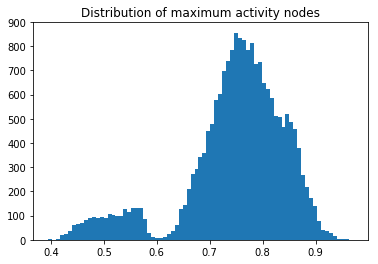

In [11]:
# plot the histogram of output values
dreamY_max = np.amax(dreamY_a, axis=1) # take maximum value of every output vector
plt.hist(dreamY_max, bins='auto')  
plt.title("Distribution of maximum activity nodes")
plt.show()

In [12]:
# # plot histogram of separate classes
# node = 9
# dreams1 = pickle.load(open("dream#"+str(node)+"_a.p", "rb"))
# dreamY = model.predict(dreams1)
# dreamY_max = dreamY[:,node]
# plt.hist(dreamY_max, bins='auto')  
# plt.title("Distribution of maximum activity nodes")
# plt.show()

Use data B together with dreams for training

100% |########################################################################|


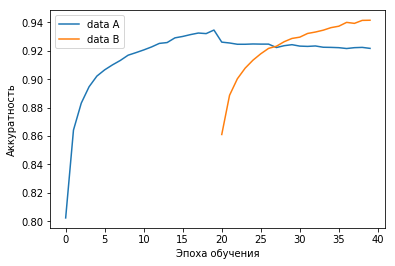

In [13]:
# Unfreeze all the layers before training
for layer in model.layers:
    layer.trainable = True
    
if os.path.isfile('weights_ab.h5'): # if network was trained before
    model.load_weights("weights_ab.h5") # load weights
    score_ab = np.load('score_ab.npy') # load training history for data A and B
    order_b = np.loadtxt('order_b.txt', dtype=int) # load permutation order of data B
    # Restore permutted data B
    tr_b = X_train[:,order_b]
    ts_b = X_test[:,order_b]
else: # train network from begining if not trained before
    # construct B data
    order_b = np.random.permutation(img_line)
    np.savetxt('order_b.txt', order_b, fmt='%d') # save permutation order for data B
    tr_b = X_train[:,order_b]
    ts_b = X_test[:,order_b]

    tr_ab = np.concatenate((tr_b, dreams_a), axis=0) # add pseudodata to the training data
    Y_ab = np.concatenate((Y_train, dreamY_a), axis=0) # add pseudotargets to the targets

    # permute training samples for proper validation set
    order_all = np.random.permutation(tr_ab.shape[0])
    tr_ab = tr_ab[order_all,:]
    Y_ab = Y_ab[order_all,:]

    score_ab = np.zeros((num_epoch,3))
    pbar = ProgressBar(maxval=num_epoch).start()
    for epoch in range(num_epoch):
        model.fit(tr_ab, Y_ab, batch_size=bsize, epochs=1, verbose=0)
        score1 = model.evaluate(ts_a, Y_test, verbose=0)
        score2 = model.evaluate(ts_b, Y_test, verbose=0)
        score_ab[epoch,:] = [epoch+num_epoch,score1[1],score2[1]]
        pbar.update(epoch+1)
    pbar.finish()
    model.save_weights('weights_ab.h5') # save weights for further use
    np.save('score_ab', score_ab) # save the history of training

# plot the accuracy of training
plt.plot(np.hstack((score_a[:,0],score_ab[:,0])),np.hstack((score_a[:,1],score_ab[:,1])),label='data A')
plt.plot(score_ab[:,0],score_ab[:,2],label='data B')
plt.xlabel('Эпоха обучения')
plt.ylabel('Аккуратность')
plt.legend()
plt.show()

## Generate dreams about data A and B

In [14]:
# Freeze all the layers in the trained network
for layer in model.layers:
    layer.trainable = False
    
# Create network for dreams production
model_dream = Sequential()
model_dream.add(Dense(img_line,input_dim=1,kernel_initializer="uniform",
                      kernel_regularizer=regularizers.l2(ll2),activation='sigmoid',use_bias=False))
model_dream.add(model)
sgd = optimizers.SGD(lr=llr)
model_dream.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=["accuracy"])

Generate an array of dreams about data A and B starting from a random noise

In [15]:
early_stopping = EarlyStopping(monitor='loss', min_delta=min_delta)

x_in = np.array([[1]])
for node in range(num_class): # generate dreams for every output node
    y_out = np.zeros((1,num_class))
    y_out[0][node] = 1 # create output target
    print('Creating dreams for node #%d' % (node))
    pbar = ProgressBar(maxval=nb_dreams).start()
    dreams = np.zeros((nb_dreams,img_line))
    for ind in range(nb_dreams):
        weights = np.array([[2*np.random.randn(img_line)]])
        model_dream.layers[0].set_weights(weights) # initialize dream with random distribution 
        model_dream.fit(x_in,y_out,batch_size=1,epochs=dream_epochs,verbose=0,shuffle=False,callbacks=[early_stopping])
        dream = expit(model_dream.layers[0].get_weights()[0]) # output of the first layer = input pattern
        dreams[ind,:] = dream
        pbar.update(ind+1)
    pbar.finish()
    pickle.dump(dreams, open("dream#"+str(node)+"_ab.p", "wb"))

Creating dreams for node #0


100% |########################################################################|


Creating dreams for node #1


100% |########################################################################|


Creating dreams for node #2


100% |########################################################################|


Creating dreams for node #3


100% |########################################################################|


Creating dreams for node #4


100% |########################################################################|


Creating dreams for node #5


100% |########################################################################|


Creating dreams for node #6


100% |########################################################################|


Creating dreams for node #7


100% |########################################################################|


Creating dreams for node #8


100% |########################################################################|


Creating dreams for node #9


100% |########################################################################|


## Training network on data C

In [16]:
# Read dreams from a disk
dreams_ab = np.empty((0,img_line),np.float32)
for node in range(num_class): # load dreams from a disk
    dream = pickle.load(open("dream#"+str(node)+"_ab.p", "rb"))
    dreams_ab = np.vstack((dreams_ab,dream))

# mix classes of dreams
order_all = np.random.permutation(dreams_ab.shape[0])
dreams_ab = dreams_ab[order_all,:]
dreamsY_ab = model.predict(dreams_ab)

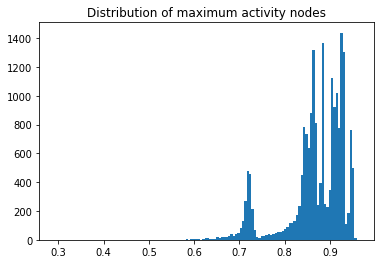

In [17]:
# plot the histogram of output values
dreamY_max = np.amax(dreamsY_ab, axis=1) # take maximum value of every output vector
plt.hist(dreamY_max, bins='auto')  
plt.title("Distribution of maximum activity nodes")
plt.show()

100% |########################################################################|


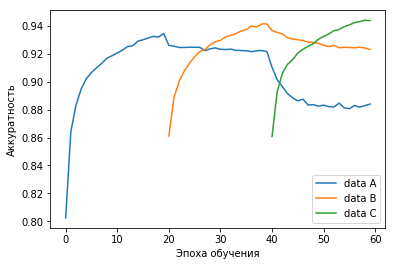

In [18]:
# Unfreeze all the layers before training
for layer in model.layers:
    layer.trainable = True

# create dataset C
order_c = np.random.permutation(img_line)
tr_c = X_train[:,order_c]
ts_c = X_test[:,order_c]

# add pseudodata to the training data
tr_abc = np.concatenate((tr_c, dreams_ab), axis=0) 
Y_abc = np.concatenate((Y_train, dreamsY_ab), axis=0)
# permute training samples for proper validation set
order_all = np.random.permutation(tr_abc.shape[0])
tr_abc = tr_abc[order_all,:]
Y_abc = Y_abc[order_all,:]

score_abc = np.zeros((num_epoch,4))
pbar = ProgressBar(maxval=num_epoch).start()
for epoch in range(num_epoch):
    model.fit(tr_abc, Y_abc, batch_size=bsize, epochs=1, verbose=0)
    score1 = model.evaluate(ts_a, Y_test, verbose=0)
    score2 = model.evaluate(ts_b, Y_test, verbose=0)
    score3 = model.evaluate(ts_c, Y_test, verbose=0)
    score_abc[epoch,:] = [epoch+num_epoch*2,score1[1],score2[1],score3[1]]
    pbar.update(epoch+1)
pbar.finish()

#plot training history
plt.plot(np.concatenate((score_a[:,0],score_ab[:,0],score_abc[:,0]),axis=0),
         np.concatenate((score_a[:,1],score_ab[:,1],score_abc[:,1]),axis=0),label='data A')
plt.plot(np.hstack((score_ab[:,0],score_abc[:,0])),np.hstack((score_ab[:,2],score_abc[:,2])),label='data B')
plt.plot(score_abc[:,0],score_abc[:,3],label='data C')
plt.xlabel('Эпоха обучения')
plt.ylabel('Аккуратность')
plt.legend()
plt.show()

In [19]:
np.savez('Dreams_0',score_a=score_a,score_ab=score_ab,score_abc=score_abc)